<a href="https://colab.research.google.com/github/LunaTic-Neon/2025-2-RL/blob/main/25_2_1105_%EA%B0%95%ED%99%94%ED%95%99%EC%8A%B5_10%EC%A3%BC%EC%B0%A8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import random
import time

# -------------------------------
# T1 0 1 2 3 4 T2
# -------------------------------


class RandomWalk():
    def __init__(
            self,
            num_internal_states=5,        # 종료 상태를 제외한 내부 상태 개수
            transition_reward=0.0,        # 일반적인 상태 전이 보상
            left_terminal_reward=0.0,     # 왼쪽 종료 상태로 이동하는 행동
                                          # 수행 시 받는 보상
            right_terminal_reward=1.0     # 오른쪽 종료 상태로 이동하는 행동
                                          # 수행 시 받는 보상
    ):
        self.__version__ = "0.0.1"

        self.num_internal_states = num_internal_states

        self.num_states = num_internal_states + 2
        self.STATES = [i for i in range(num_internal_states)]
        self.TERMINAL_STATES = ['T1', 'T2']

        # 모든 가능한 행동
        self.ACTION_LEFT = 0
        self.ACTION_RIGHT = 1
        self.ACTION_SYMBOLS = ["\u2190", "\u2192"]

        # 종료 상태를 제외한 임의의 상태에서 왼쪽 이동 또는 오른쪽 이동
        self.ACTIONS = [
            self.ACTION_LEFT,
            self.ACTION_RIGHT
        ]
        self.NUM_ACTIONS = len(self.ACTIONS)

        # 시작 상태 위치
        self.START_STATE = self.STATES[int(num_internal_states / 2)]

        self.transition_reward = transition_reward

        self.left_terminal_reward = left_terminal_reward

        self.right_terminal_reward = right_terminal_reward

        self.current_state = None

    def reset(self):
        self.current_state = self.START_STATE
        return self.current_state

    def moveto(self, state):
        self.current_state = state

    def get_next_state(self, state, action):
        if state in self.TERMINAL_STATES:
            next_state = state
        else:
            if action == self.ACTION_LEFT:
                if state == 0:
                    next_state = 'T1'
                else:
                    next_state = state - 1
            elif action == self.ACTION_RIGHT:
                if state == self.num_internal_states - 1:
                    next_state = 'T2'
                else:
                    next_state = state + 1
            else:
                raise ValueError()

        return next_state

    def get_reward(self, state, next_state):
        if next_state == 'T1':
            reward = self.left_terminal_reward
        elif next_state == 'T2':
            reward = self.right_terminal_reward
        else:
            reward = self.transition_reward

        return reward

    def get_state_action_probability(self, state, action):
        next_state = self.get_next_state(state, action)

        reward = self.get_reward(state, next_state)
        prob = 1.0

        return next_state, reward, prob

    # take @action in @state
    # @return: (reward, new state)
    def step(self, action):
        next_state = self.get_next_state(
            state=self.current_state, action=action
        )

        reward = self.get_reward(self.current_state, next_state)

        self.current_state = next_state

        if self.current_state in self.TERMINAL_STATES:
            done = True
        else:
            done = False

        return next_state, reward, done, None

    def render(self, mode='human'):
        print(self.__str__(), end="\n\n")

    def get_random_action(self):
        return random.choice(self.ACTIONS)

    def __str__(self):
        randomwalk_str = ""
        randomwalk_str += " T1 " + " ".join(
            ["{0}".format(i) for i in range(self.num_internal_states)]
        ) + " T2\n"

        if self.current_state in self.STATES:
            blank = "    " + "  " * self.current_state
        elif self.current_state == 'T1':
            blank = " "
        elif self.current_state == 'T2':
            blank = "  " + "  " * (self.num_internal_states + 1)
        else:
            raise ValueError()

        randomwalk_str += blank + "*"

        return randomwalk_str

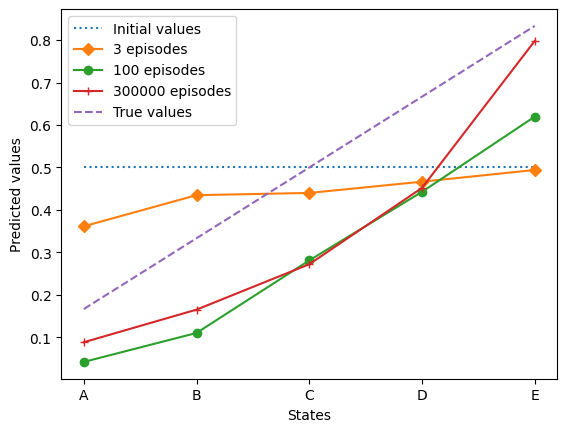

In [2]:
import numpy as np
import os
import matplotlib.pyplot as plt

NUM_INTERNAL_STATES = 5

# 0: 왼쪽 종료 상태 T1를 나타냄, 상태 가치는 0.0으로 변하지 않음
# 6: 오른쪽 종료 상태 T2를 나타냄, 상태 가치는 1.0으로 변하지 않음
# 1부터 5는 각각 차례로 상태 A부터 상태 E를 나타냄, 각 상태 가치는 0.5로 초기화됨
VALUES = np.zeros(NUM_INTERNAL_STATES)
VALUES[0:NUM_INTERNAL_STATES] = 0.5

# 올바른 상태 가치 값 저장
TRUE_VALUES = np.zeros(NUM_INTERNAL_STATES)
TRUE_VALUES[0:NUM_INTERNAL_STATES] = np.arange(1, 6) / 6.0

# 모든 상태에서 수행 가능한 행동에 맞춰 임의의 정책을 생성함
# 초기에 각 행동의 선택 확률은 모두 같음
def generate_initial_random_policy(env):
    policy = dict()

    for state in env.STATES:
        actions = []
        prob = []
        for action in range(env.NUM_ACTIONS):
            actions.append(action)
            prob.append(0.5)
        policy[state] = (actions, prob)

    return policy

def temporal_difference(env, policy, state_values, alpha=0.1, gamma=0.9):
    done = False
    state = env.reset()

    while not done:
        actions, prob = policy[state]
        action = np.random.choice(actions, size=1, p=prob)[0]
        next_state, reward, done, _ = env.step(action)

        if done:
            state_values[state] += alpha * (reward - state_values[state])
        else:
            state_values[state] += alpha * \
            (reward + gamma * state_values[next_state] - state_values[state])

        state = next_state
# TD를 활용한 상태 가치 추정
def compute_state_values(env):
    max_episodes = [3, 100, 300000]
    markers = ['o', '+', 'D']
    plt.figure()
    plt.plot(
        ['A', 'B', 'C', 'D', 'E'],
        VALUES, label='Initial values', linestyle=":"
    )

    policy = generate_initial_random_policy(env)
    for i in range(len(max_episodes)):
        state_values = VALUES.copy()
        for _ in range(max_episodes[i]):
            temporal_difference(env, policy, state_values)
        plt.plot(
            ['A', 'B', 'C', 'D', 'E'],
            state_values, label = str(max_episodes[i]) + ' episodes',
            marker=markers[i-1]
        )

    plt.plot(
        ['A', 'B', 'C', 'D', 'E'],
        TRUE_VALUES, label='True values', linestyle="--"
    )

    plt.xlabel('States')
    plt.ylabel('Predicted values')
    plt.legend()

    plt.show()
    plt.close()

def td_learning_main():
    # 이미지 저장 경로 확인 및 생성
    if not os.path.exists('images/'):
        os.makedirs('images/')

    env = RandomWalk(
        num_internal_states=NUM_INTERNAL_STATES,
        transition_reward=0.0,
        left_terminal_reward=0.0,
        right_terminal_reward=1.0
    )
    compute_state_values(env)

if __name__ == '__main__':
    td_learning_main()


In [5]:
import numpy as np
import random
import time

# -------------------------------
# |(0,0)|(0,1)|(0,2)|(0,3)|(0,4)|
# |(1,0)|(1,1)|(1,2)|(1,3)|(1,4)|
# |(2,0)|(2,1)|(2,2)|(2,3)|(2,4)|
# |(3,0)|(3,1)|(3,2)|(3,3)|(3,4)|
# |(4,0)|(4,1)|(4,2)|(4,3)|(4,4)|
# -------------------------------


class GridWorld():
    def __init__(
            self,
            height=5, width=5,        # 격자판의 크기
            start_state=(0, 0),       # 시작 상태
            terminal_states=[(4, 4)], # 종료 상태
            transition_reward=0.0,    # 일반적인 상태 전이 보상
            terminal_reward=1.0,      # 종료 상태로 이동하는 행동 수행
                                      # 때 받는 보상
            outward_reward=0.0,       # 미로 바깥으로 이동하는 행동 수행
                                      # 때 받는 보상
            warm_hole_states=None     # 윔홀 정의
    ):
        self.__version__ = "0.0.1"

        # 그리드월드의 세로 길이
        self.HEIGHT = height

        # 그리드월드의 가로 길이
        self.WIDTH = width

        self.STATES = []
        self.num_states = self.WIDTH * self.HEIGHT

        for i in range(self.HEIGHT):
            for j in range(self.WIDTH):
                self.STATES.append((i, j))

        # 터미널 상태를 상태 집합에서 제거
        for state in terminal_states:
            self.STATES.remove(state)

        self.current_state = None

        # 모든 가능한 행동
        self.ACTION_UP = 0
        self.ACTION_DOWN = 1
        self.ACTION_LEFT = 2
        self.ACTION_RIGHT = 3

        self.ACTIONS = [
            self.ACTION_UP,
            self.ACTION_DOWN,
            self.ACTION_LEFT,
            self.ACTION_RIGHT
        ]

        # UP, DOWN, LEFT, RIGHT
        self.ACTION_SYMBOLS = ["↑", "↓", "←", "→"]

        self.NUM_ACTIONS = len(self.ACTIONS)

        # 시작 상태 위치
        self.START_STATE = start_state

        # 종료 상태 위치
        self.TERMINAL_STATES = terminal_states

        # 웜홀 상태 위치
        self.WARM_HOLE_STATES = warm_hole_states

        # 일반 상태 전이 수행에 대한 보상 값
        self.transition_reward = transition_reward

        # 종료 상태 전이 수행에 대한 보상 값
        self.terminal_reward = terminal_reward

        # 그리드월드 바깥으로 상태 전이 수행해 대한 보상 값
        self.outward_reward = outward_reward


    # 환경 초기화 작업: 에이전트의 현재 위치를 START_STATE로 설정
    def reset(self):
        self.current_state = self.START_STATE
        return self.current_state

    # 에이전트의 현재 위치를 state로 설정
    def moveto(self, state):
        self.current_state = state

    # 주어진 state 상태가 웜홀 상태이면 True 반환하고, 아니면 False 반환
    def is_warm_hole_state(self, state):
        i, j = state

        if self.WARM_HOLE_STATES is not None \
            and len(self.WARM_HOLE_STATES) > 0:
            for warm_hole_info in self.WARM_HOLE_STATES:
                warm_hole_state = warm_hole_info[0]
                if i == warm_hole_state[0] and j == warm_hole_state[1]:
                    return True
        return False

    # 주어진 웜홀 상태 state에 대하여 미리 정해져 있는 다음 상태 반환
    def get_next_state_warm_hole(self, state):
        i, j = state
        next_state = None

        for warm_hole_info in self.WARM_HOLE_STATES:
            warm_hole_state = warm_hole_info[0]
            warm_hole_prime_state = warm_hole_info[1]

            if i == warm_hole_state[0] and j == warm_hole_state[1]:
                next_state = warm_hole_prime_state
                break
        return next_state

    # 주어진 웜홀 상태 state에 대하여 미리 정해져 있는 보상 반환
    def get_reward_warm_hole(self, state):
        i, j = state
        reward = None

        for warm_hole_info in self.WARM_HOLE_STATES:
            warm_hole_state = warm_hole_info[0]
            warm_hole_reward = warm_hole_info[2]

            if i == warm_hole_state[0] and j == warm_hole_state[1]:
                reward = warm_hole_reward
                break

        return reward

    # 주어진 상태 state와 행동 action에 대한 다음 상태 반환
    def get_next_state(self, state, action):
        i, j = state

        # 주어진 상태가 웜홀 상태이면 미리 정해진 다음 상태를 반환
        if self.is_warm_hole_state(state):
            next_state = self.get_next_state_warm_hole(state)
            next_i = next_state[0]
            next_j = next_state[1]
        # 주어진 상태가 종료 상태이면 현재 상태를
        # 다음 상태로 설정하여 반환
        elif (i, j) in self.TERMINAL_STATES:
            next_i = i
            next_j = j
        # 주어진 행동 수행에 따른 다음 상태 반환
        # 주어진 행동에 의하여 그리드월드 밖으로 이동하는 경우
        # 제자리에 멈춤
        else:
            if action == self.ACTION_UP:
                next_i = max(i - 1, 0)
                next_j = j
            elif action == self.ACTION_DOWN:
                next_i = min(i + 1, self.HEIGHT - 1)
                next_j = j
            elif action == self.ACTION_LEFT:
                next_i = i
                next_j = max(j - 1, 0)
            elif action == self.ACTION_RIGHT:
                next_i = i
                next_j = min(j + 1, self.WIDTH - 1)
            else:
                raise ValueError()

        return next_i, next_j

    # 주어진 상태 state에서 다음 상태 next_state로 이동할 경우
    # 얻는 보상 반환
    def get_reward(self, state, next_state):
        i, j = state
        next_i, next_j = next_state

        # 주어진 상태가 웜홀 상태이면 미리 정해진 보상 반환
        if self.is_warm_hole_state(state):
            reward = self.get_reward_warm_hole(state)
        else:
            # 다음 상태가 종료 상태이면 미리 정해진 보상 반환
            if (next_i, next_j) in self.TERMINAL_STATES:
                reward = self.terminal_reward
            else:
                # 주어진 행동에 의하여 그리드월드 밖으로 이동하는 경우
                # 제자리에 멈추면서 미리 정해진 보상 반환
                if i == next_i and j == next_j:
                    reward = self.outward_reward
                # 일반적인 상태 전이인 경우 미리 정해진
                # 일반 전이 보상 반환
                else:
                    reward = self.transition_reward

        return reward

    # 주어진 상태 state에서 행동 action을 수행할 때 전이되는
    # 다음 상태 및 보상과 이에 대한 전이 확률을 반환
    def get_state_action_probability(self, state, action):
        next_i, next_j = self.get_next_state(state, action)

        reward = self.get_reward(state, (next_i, next_j))
        transition_prob = 1.0

        return (next_i, next_j), reward, transition_prob

    # 에이전트가 행동 action을 선택하여 환경에 적용할 때 호출하는 함수
    # 행동 action이 수행된 이후 전이된 다음 상태, 보상, 종료 유무 반환
    def step(self, action):
        next_i, next_j = self.get_next_state(
            state=self.current_state, action=action
        )

        reward = self.get_reward(self.current_state, (next_i, next_j))

        self.current_state = (next_i, next_j)

        if self.current_state in self.TERMINAL_STATES:
            done = True
        else:
            done = False

        return (next_i, next_j), reward, done, None

    # 그리드월드 환경을 화면에 출력
    def render(self, mode='human'):
        print(self.__str__())

    # 임의의 행동을 선택하여 반환
    def get_random_action(self):
        return random.choice(self.ACTIONS)

    # 그리드월드 환경을 문자열로 변환
    def __str__(self):
        gridworld_str = ""
        for i in range(self.HEIGHT):
            gridworld_str += "-------------------------------\n"

            for j in range(self.WIDTH):
                if self.current_state[0] == i and self.current_state[1] == j:
                    gridworld_str += "|  {0}  ".format("*")
                elif (i, j) == self.START_STATE:
                    gridworld_str += "|  {0}  ".format("S")
                elif (i, j) in self.TERMINAL_STATES:
                    gridworld_str += "|  {0}  ".format("G")
                elif self.WARM_HOLE_STATES and \
                     (i, j) in [state[0] for state in self.WARM_HOLE_STATES]:
                    gridworld_str += "|  {0}  ".format("W")
                else:
                    gridworld_str += "|     "
            gridworld_str += "|\n"

            for j in range(self.WIDTH):
                gridworld_str += "|({0},{1})".format(i, j)

            gridworld_str += "|\n"

        gridworld_str += "-------------------------------\n"
        return gridworld_str
import matplotlib.pyplot as plt
from matplotlib.table import Table

# 학습 이후의 가치함수를 표 형태로 그리는 함수
def draw_grid_world_state_values_image(state_values, GRID_HEIGHT, GRID_WIDTH):

    # 축 표시 제거, 크기 조절 등 이미지 그리기를 위한 설정
    fig, ax = plt.subplots()
    ax.set_axis_off()
    table = Table(ax, bbox=[0, 0, 1, 1])

    nrows, ncols = GRID_HEIGHT, GRID_WIDTH
    width, height = 1.0 / ncols, 1.0 / nrows

    # 렌더링 할 이미지에 표 셀과 해당 값 추가
    for i in range(GRID_HEIGHT):
        for j in range(GRID_WIDTH):
            table.add_cell(
                i, j, width, height,
                text=np.round(state_values[i][j], decimals=2),
                loc='center', facecolor='white'
            )

    # 행, 열 라벨 추가
    for i in range(len(state_values)):
        table.add_cell(
            i, -1, width, height,
            text=i+1, loc='right', edgecolor='none', facecolor='none'
        )
        table.add_cell(
            -1, i, width, height/2,
            text=i+1, loc='center', edgecolor='none', facecolor='none'
        )

    for key, cell in table.get_celld().items():
         cell.get_text().set_fontsize(20)

    ax.add_table(table)

    plt.show()
    plt.close()


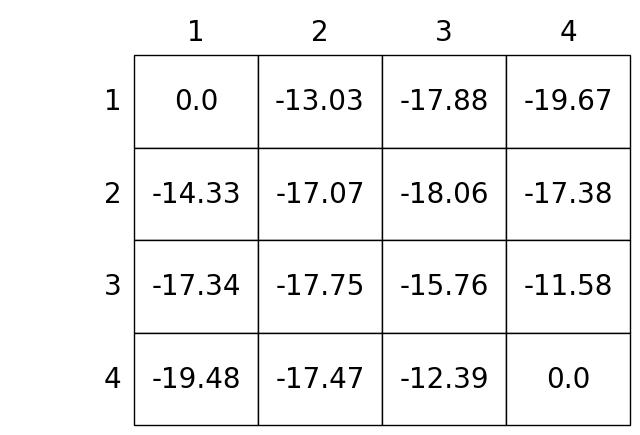

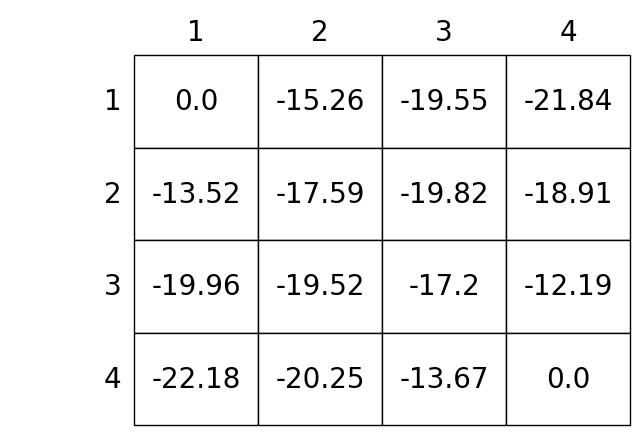

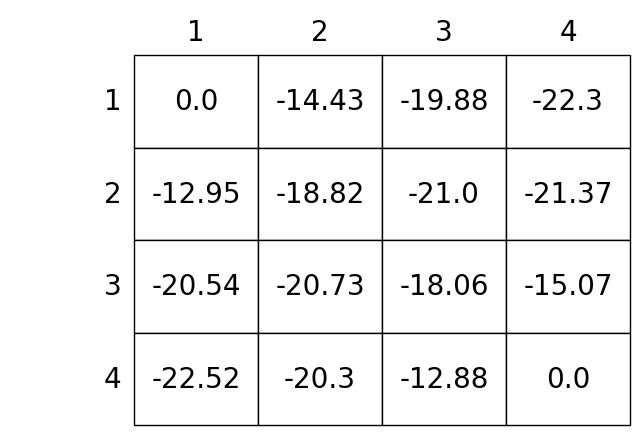

In [6]:
GRID_HEIGHT = 4
GRID_WIDTH = 4
NUM_ACTIONS = 4
TERMINAL_STATES = [(0, 0), (GRID_HEIGHT-1, GRID_WIDTH-1)]

def generate_initial_state_values():
    state_values = np.zeros(shape=(GRID_HEIGHT, GRID_WIDTH))
    for i in range(GRID_HEIGHT):
        for j in range(GRID_WIDTH):
            state_values[i, j] = 0.0
    return state_values

# 모든 상태에서 수행 가능한 행동에 맞춰 임의의 정책을 생성함
# 초기에 각 행동의 선택 확률은 모두 같음
def generate_initial_random_policy(env):
    policy = dict()

    for i in range(GRID_HEIGHT):
        for j in range(GRID_WIDTH):
            actions = []
            prob = []
            for action in range(NUM_ACTIONS):
                actions.append(action)
                prob.append(0.25)
            policy[(i, j)] = (actions, prob)

    return policy

def get_exploring_start_state():
    while True:
        i = random.randrange(GRID_HEIGHT)
        j = random.randrange(GRID_WIDTH)
        if (i, j) not in TERMINAL_STATES:
            break
    return (i, j)
def temporal_difference(env, policy, state_values, alpha=0.1):
    env.reset()

    initial_state = get_exploring_start_state()
    env.moveto(initial_state)

    done = False
    state = env.current_state
    while not done:
        actions, prob = policy[state]
        action = np.random.choice(actions, size=1, p=prob)[0]
        next_state, reward, done, _ = env.step(action)

        if done:
            state_values[state] += alpha * (reward - state_values[state])
        else:
            state_values[state] += alpha * \
            (reward + state_values[next_state] - state_values[state])

        state = next_state

def compute_state_values(env, alpha):
    policy = generate_initial_random_policy(env)

    state_values = generate_initial_state_values()
    max_episodes = 1000
    for _ in range(max_episodes):
        temporal_difference(env, policy, state_values, alpha)

    draw_grid_world_state_values_image(state_values, GRID_HEIGHT, GRID_WIDTH)

    state_values = generate_initial_state_values()
    max_episodes = 10000
    for _ in range(max_episodes):
        temporal_difference(env, policy, state_values, alpha)

    draw_grid_world_state_values_image(state_values, GRID_HEIGHT, GRID_WIDTH)

    state_values = generate_initial_state_values()
    max_episodes = 100000
    for _ in range(max_episodes):
        temporal_difference(env, policy, state_values, alpha)

    draw_grid_world_state_values_image(state_values, GRID_HEIGHT, GRID_WIDTH)

def td_learning_main():
    env = GridWorld(
        height=GRID_HEIGHT,
        width=GRID_WIDTH,
        start_state=(2, 2),
        terminal_states=TERMINAL_STATES,
        transition_reward=-1.0,
        terminal_reward=-1.0,
        outward_reward=-1.0
    )
    compute_state_values(env, alpha=0.05)

if __name__ == '__main__':
    td_learning_main()


alpha=0.03
method: TD, run: 0
method: TD, run: 1
method: TD, run: 2
method: TD, run: 3
method: TD, run: 4
method: TD_batch, run: 0
method: TD_batch, run: 1
method: TD_batch, run: 2
method: TD_batch, run: 3
method: TD_batch, run: 4


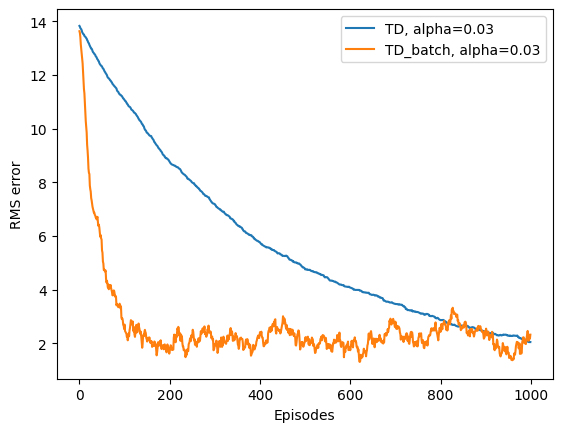

alpha=0.003
method: TD, run: 0
method: TD, run: 1
method: TD, run: 2
method: TD, run: 3
method: TD, run: 4
method: TD_batch, run: 0
method: TD_batch, run: 1
method: TD_batch, run: 2
method: TD_batch, run: 3
method: TD_batch, run: 4


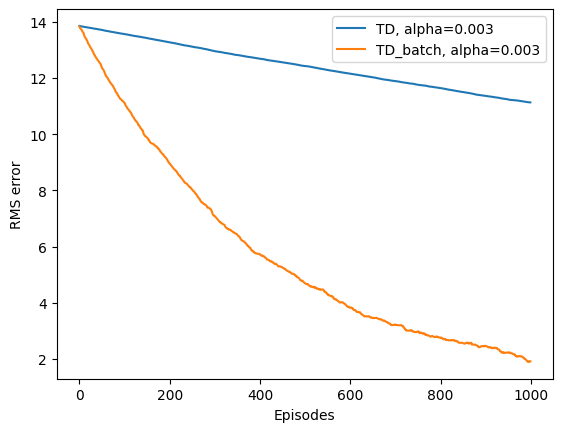

In [9]:
GRID_HEIGHT = 4
GRID_WIDTH = 4
NUM_ACTIONS = 4
TERMINAL_STATES = [(0, 0), (GRID_HEIGHT-1, GRID_WIDTH-1)]

MAX_EPISODES = 1000

VALUES = np.zeros(shape=(GRID_HEIGHT, GRID_WIDTH))
for i in range(GRID_HEIGHT):
    for j in range(GRID_WIDTH):
        VALUES[i, j] = 0.0

# 올바른 상태 가치 값 저장
TRUE_VALUES = np.zeros(shape=(GRID_HEIGHT, GRID_WIDTH))
TRUE_VALUES[0, 0] = 0.0;   TRUE_VALUES[0, 1] = -14.0;
TRUE_VALUES[0, 2] = -20.0; TRUE_VALUES[0, 3] = -22.0
TRUE_VALUES[1, 0] = -14.0; TRUE_VALUES[1, 1] = -18.0;
TRUE_VALUES[1, 2] = -20.0; TRUE_VALUES[1, 3] = -20.0
TRUE_VALUES[2, 0] = -20.0; TRUE_VALUES[2, 1] = -20.0;
TRUE_VALUES[2, 2] = -18.0; TRUE_VALUES[2, 3] = -14.0
TRUE_VALUES[3, 0] = -22.0; TRUE_VALUES[3, 1] = -20.0;
TRUE_VALUES[3, 2] = -14.0; TRUE_VALUES[3, 3] = 0.0

def generate_initial_state_values():
    state_values = np.zeros(shape=(GRID_HEIGHT, GRID_WIDTH))
    for i in range(GRID_HEIGHT):
        for j in range(GRID_WIDTH):
            state_values[i, j] = 0.0
    return state_values

# 모든 상태에서 수행 가능한 행동에 맞춰 임의의 정책을 생성함
# 초기에 각 행동의 선택 확률은 모두 같음
def generate_initial_random_policy(env):
    policy = dict()

    for i in range(GRID_HEIGHT):
        for j in range(GRID_WIDTH):
            actions = []
            prob = []
            for action in range(NUM_ACTIONS):
                actions.append(action)
                prob.append(0.25)
            policy[(i, j)] = (actions, prob)

    return policy

# 탐험적 시작
def get_exploring_start_state():
    while True:
        i = random.randrange(GRID_HEIGHT)
        j = random.randrange(GRID_WIDTH)
        if (i, j) not in TERMINAL_STATES:
            break
    return (i, j)

# TD 수행 함수
def temporal_difference(env, policy, state_values, alpha, gamma=1.0):
    env.reset()

    initial_state = get_exploring_start_state()
    env.moveto(initial_state)

    done = False
    state = env.current_state
    while not done:
        actions, prob = policy[state]
        action = np.random.choice(actions, size=1, p=prob)[0]
        next_state, reward, done, _ = env.step(action)

        if done:
            state_values[state] += alpha * (reward - state_values[state])
        else:
            state_values[state] += alpha * \
            (reward + gamma * state_values[next_state] - state_values[state])

        state = next_state
# TD_batch 수행 함수
def temporal_difference_batch(
    env, policy, state_values, alpha, gamma=1.0, num_batch_updates=10):
    env.reset()

    initial_state = get_exploring_start_state()
    env.moveto(initial_state)

    batch_list = []

    done = False
    state = env.current_state
    while not done:
        actions, prob = policy[state]
        action = np.random.choice(actions, size=1, p=prob)[0]
        next_state, reward, done, _ = env.step(action)

        batch_list.append([state, action, next_state, reward, done])

        state = next_state

    for i in range(num_batch_updates):
        for sample in batch_list:
            state = sample[0]
            next_state = sample[2]
            reward = sample[3]
            done = sample[4]

            if done:
                state_values[state] += alpha * (reward - state_values[state])
            else:
                state_values[state] += alpha * \
                (reward + gamma * state_values[next_state] - state_values[state])
# @method: 'TD' 또는 'TD_batch'
def batch_updating(env, method, alpha):
    policy = generate_initial_random_policy(env)

    # episodes 수행 마다 독립적인 에러값 모음
    total_errors = np.zeros(MAX_EPISODES)

    total_runs = 5
    for run in range(total_runs):
        errors = []
        state_values = np.copy(VALUES)

        for _ in range(MAX_EPISODES):
            if method == 'TD':
                temporal_difference(env, policy, state_values, alpha=alpha)
            else:
                temporal_difference_batch(
                    env, policy, state_values, alpha=alpha, num_batch_updates=10
                )
            errors.append(
                np.sqrt(np.sum(np.power(TRUE_VALUES - state_values, 2)) / 25)
            )

        total_errors += np.asarray(errors)
        print("method: {0}, run: {1}".format(method, run))
    total_errors /= total_runs

    return total_errors

def mc_td_batch_comparison(env, alpha):
    td_errors = batch_updating(env, 'TD', alpha=alpha)
    td_batch_errors = batch_updating(env, 'TD_batch', alpha=alpha)

    plt.plot(td_errors, label='TD, alpha={0}'.format(alpha))
    plt.plot(td_batch_errors, label='TD_batch, alpha={0}'.format(alpha))
    plt.xlabel('Episodes')
    plt.ylabel('RMS error')
    plt.legend()

    plt.show()
    plt.close()

def td_batch_comparison_main():
    env = GridWorld(
        height=GRID_HEIGHT,
        width=GRID_WIDTH,
        start_state=(2, 2),
        terminal_states=TERMINAL_STATES,
        transition_reward=-1.0,
        terminal_reward=-1.0,
        outward_reward=-1.0
    )
    print("alpha={0}".format(0.03))
    mc_td_batch_comparison(env, alpha=0.03)

    print("alpha={0}".format(0.003))
    mc_td_batch_comparison(env, alpha=0.003)

if __name__ == '__main__':
    td_batch_comparison_main()

